In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import os.path
import numpy as np

import matplotlib.pyplot as plt


import jaxmaze_trainer as trainer
import housemaze
from housemaze import levels
from housemaze import utils
from housemaze import renderer
from housemaze.env import KeyboardActions
from housemaze.human_dyna import multitask_env
from housemaze.human_dyna import mazes
from housemaze.human_dyna import sf_task_runner
from housemaze.human_dyna import experiments

/Users/wilka/git/research/preplay_ai_experiment/.venv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Loading Craftax textures from cache.
Textures successfully loaded from cache.


In [4]:
%matplotlib inline

In [5]:
# rendering fns
def display_image(image):
  # Create a new figure and axis
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image)

  # Remove the axis ticks and labels
  ax.axis("off")

  # Show the plot
  plt.tight_layout()
  plt.show()


def render_timestep(timestep):
  image = renderer.create_image_from_grid(
    timestep.state.grid,
    timestep.state.agent_pos,
    timestep.state.agent_dir,
    image_dict,
  )
  plt.imshow(image)
  plt.show()

No file specified for image dict.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/image_data.pkl


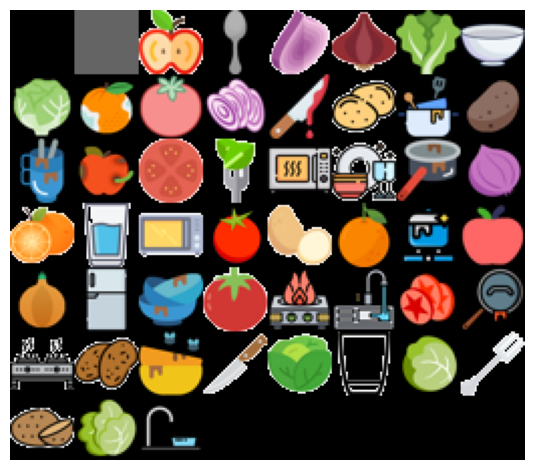

((224, 256, 3),
 ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked'])

In [6]:
# load images and display them
image_dict = utils.load_image_dict()
image = renderer.create_image_grid_from_image_tensor(image_dict["images"], max_cols=8)
display_image(image)
image.shape, image_dict["keys"][:5]

In [7]:
char2idx, groups, task_objects = mazes.get_group_set(2)
task_runner = multitask_env.TaskRunner(
  task_objects=task_objects, terminate_with_any=False
)

No file specified for groups.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/human_dyna/list_of_groups.npy


In [8]:
task_objects = groups.reshape(-1)
task_objects

array([26, 40, 47, 43], dtype=int32)

No file specified for groups.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/human_dyna/list_of_groups.npy


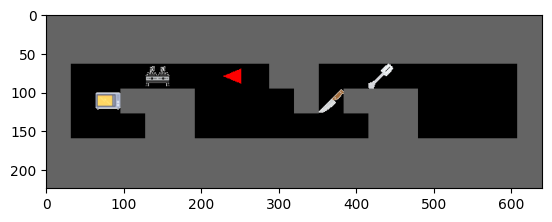

Array([0., 0., 0., 0.], dtype=float32)

In [47]:
def get_params(maze_name: str = "maze0"):
  """Get train and test params for a maze using basic_make_exp_block.

  Args:
    maze_name: Name of the maze (e.g., "her_test", "maze3")

  Returns:
    train_params, test_params, task_objects, label2name
  """
  return experiments.basic_make_exp_block(
    config={},
    train_mazes=[maze_name],
    eval_mazes=[maze_name],
    include_rotations=False,
    train_curriculum=False,
  )


train_params, test_params, task_objects, label2name = get_params("her_test")

task_actions = [
  KeyboardActions.left,
  KeyboardActions.left,
  KeyboardActions.left,
  KeyboardActions.left,
  KeyboardActions.left,
  KeyboardActions.down,
]

seed = 7
rng = jax.random.PRNGKey(seed)

env = multitask_env.HouseMaze(
  task_runner=multitask_env.TaskRunner(
    task_objects=task_objects, terminate_with_any=False
  ),
  num_categories=len(image_dict["keys"]),
)
env = utils.AutoResetWrapper(env)

reset = jax.jit(env.reset)
reset_timestep = reset(rng, train_params)
render_timestep(reset_timestep)
reset_timestep.observation.state_features

is_train_task: True


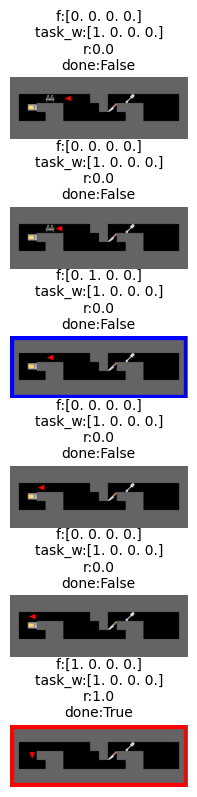

In [49]:
from matplotlib.patches import Rectangle


def visualize_trajectory(actions, env, env_params, rng, image_dict, scale=2 / 3):
  """Visualize a trajectory through the environment.

  Args:
    initial_timestep: Starting timestep
    actions: List of actions to take
    env: The environment
    env_params: Environment parameters
    rng: Random key
    image_dict: Dictionary of images for rendering
    scale: Image scale factor (default 2/3)
  """
  # First pass: collect timesteps until termination
  timesteps = []
  initial_timestep = reset(rng, env_params)
  timestep = initial_timestep
  for a in actions:
    rng, rng_ = jax.random.split(rng)
    timestep = env.step(rng_, timestep, a, env_params)
    timesteps.append(timestep)
    if timestep.last():
      break
  print("is_train_task:", timestep.state.is_train_task)
  n_steps = len(timesteps)
  fig, axes = plt.subplots(n_steps, 1, figsize=(4 * scale, 2 * scale * n_steps))

  if n_steps == 1:
    axes = [axes]

  for i, timestep in enumerate(timesteps):
    image = renderer.create_image_from_grid(
      timestep.state.grid,
      timestep.state.agent_pos,
      timestep.state.agent_dir,
      image_dict,
    )

    ax = axes[i]
    ax.imshow(image)
    ax.axis("off")

    # Build title
    features = timestep.observation.state_features
    task_w = timestep.observation.task_w
    reward = float(timestep.reward)
    discount = float(timestep.discount)

    title = f"f:{features}\ntask_w:{task_w}\nr:{reward:.1f}\ndone:{discount == 0}"
    ax.set_title(title, fontsize=10)

    # Add colored border: red for reward, blue for nonzero features
    has_reward = reward != 0
    has_features = np.any(np.array(features) != 0)

    if has_reward or has_features:
      color = "red" if has_reward else "blue"
      # Add rectangle border around the image
      rect = Rectangle(
        (0, 0),
        image.shape[1],
        image.shape[0],
        linewidth=6,
        edgecolor=color,
        facecolor="none",
      )
      ax.add_patch(rect)

  plt.tight_layout()
  plt.show()


# Example usage:
visualize_trajectory(task_actions, env, train_params, rng, image_dict)

is_train_task: True


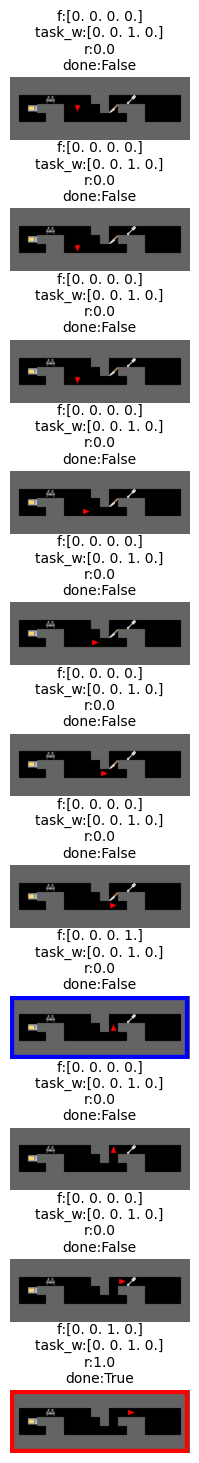

In [61]:
# rng, rng_train_right = jax.random.split(rng)
test_params = test_params.replace(p_test_sample_train=jnp.array(0.0))
task_actions = [
  KeyboardActions.down,
  KeyboardActions.down,
  KeyboardActions.down,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.up,
  KeyboardActions.up,
  KeyboardActions.right,
  KeyboardActions.right,
]

visualize_trajectory(task_actions, env, train_params, rng_train_right, image_dict)

is_train_task: False


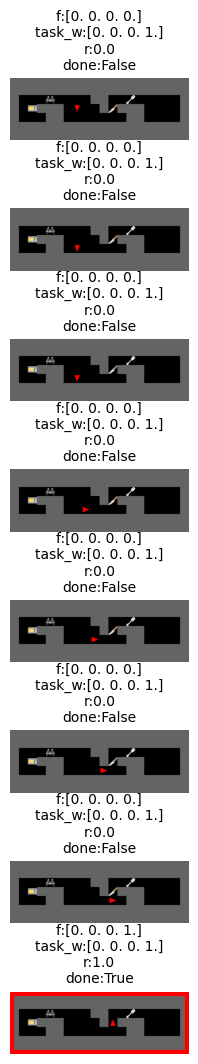

In [55]:
# rng, rng_test_right = jax.random.split(rng)
rng_test_right = rng_
test_params = test_params.replace(p_test_sample_train=jnp.array(0.0))
task_actions = [
  KeyboardActions.down,
  KeyboardActions.down,
  KeyboardActions.down,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.right,
  KeyboardActions.up,
  KeyboardActions.up,
]

visualize_trajectory(task_actions, env, test_params, rng_test_right, image_dict)